# Introduction
This notebook is about somewhat recreating this article: https://medium.com/analytics-vidhya/how-im-using-machine-learning-to-trade-in-the-stock-market-3ba981a2ffc2

The article is about using machine learning to predict stock prices. The author uses a simple feed forward neural network to predict the stock prices. The author uses the past 30 days of stock prices to predict the stock price of the next day. 

In this notebook I will try to recreate the author's work using the same steps and see how well the model performs on the test data. 

This notebook is a work in progress. It will be updated with more details and explanations. 

# Data
The data is from Yahoo finance. To train the model all tickers from S&P 500 are used.

# Model
- In this notebook we try and evaluate the Logistic Regression model.
- Two Models are tested, one using relative Volume instead of normal and the other using normal.


# Evaluation
We evualate the model by taking a percentage of the data out of the training set (15%)

# References
1. https://medium.com/analytics-vidhya/how-im-using-machine-learning-to-trade-in-the-stock-market-3ba981a2ffc2

# Imports

# Train & Test on all S&P stocks

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import logging
import os
from pathlib import Path
import pickle
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)

## Fetch data for all 500 tickers

In [9]:
def fetch_data(stocks: list, start_date: str|None=None, end_date: str|None=None, verbose: bool=False) -> dict:
    """
    fetch data for all the stocks
    """
    df_dict = {} #store the dataframes
    if not start_date or not end_date:
        logging.info('Dates not provided, fetching all data...')

    for stock in stocks:
        try:
            if verbose:
                print(f'Fetching data for {stock}...')
            tick = yf.Ticker(stock)
            if not start_date or not end_date:
                df = tick.history(period="max")
            else:
                df = tick.history(start = start_date, end = end_date)
            # First, reset the index to make the date an explicit column
            df.reset_index(inplace=True)

            # Rename the index column to 'Date' for clarity
            df.rename(columns={'index': 'Date'}, inplace=True)
            df_dict[stock] = df
        except:
            logging.warning(f'Could not fetch data for {stock}')
    logging.info('Data fetched...')
    return df_dict

In [ ]:
# Fetch the list of S&P 500 tickers
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

data_500 = fetch_data(sp500_tickers, verbose=False)

INFO:root:Dates not provided, fetching all data...


## Preprocess Data for training

- Removed rows with missing or NaN values to ensure the dataset is complete.
- Filtered out irrelevant columns that are not needed for model training.
- Created new features such as `normalized_value`, which normalizes the stock prices.
- Added a `target` column with `0` for row being local min and `1` for being local max

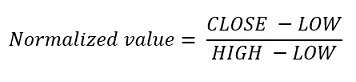
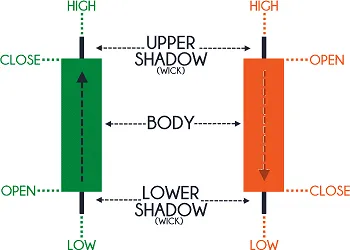

In [10]:
def linear_regression(x: np.array, y: np.array) -> float:
    """
    performs linear regression given x and y. outputs regression coefficient
    """
    #fit linear regression
    lr = LinearRegression()
    lr.fit(x, y)

    return lr.coef_[0][0]

def n_day_regression(n: int, df: pd.DataFrame, idxs: list) -> pd.DataFrame:
    """
    n day regression.
    """
    #variable
    _varname_ = f'{n}_reg'
    df[_varname_] = np.nan

    for idx in idxs:
        if idx > n:
            
            y = df['Close'][idx - n: idx].to_numpy()
            x = np.arange(0, n)
            #reshape
            y = y.reshape(y.shape[0], 1)
            x = x.reshape(x.shape[0], 1)
            #calculate regression coefficient 
            coef = linear_regression(x, y)
            df.loc[idx, _varname_] = coef #add the new value
            
    return df

def normalized_values(high: float, low: float, close: float) -> float:
    """
    normalize the price between 0 and 1.
    """
    #epsilon to avoid deletion by 0
    epsilon = 10e-10
    
    #subtract the lows
    high = high - low
    close = close - low
    return close/(high + epsilon)

In [11]:
# Modify create_train_data to include relative volume instead of volume
def relative_volume(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    calculate the relative volume
    """
    out_df = df.copy()

    out_df['Volume'] = out_df['Volume'].astype(float)
    out_df['AVG_Volume'] = out_df['Volume'].rolling(window = window).mean()
    out_df['relative_volume'] = out_df['Volume']/out_df['AVG_Volume']
    return out_df

# TODO make that a class w save option and also can make something like caching to update without running the whole thing
def create_train_data(stock_dfs: dict, n: int, volume_type="normal",verbose: bool=False) -> pd.DataFrame:
    """
    create train data for all the stocks given in a dictionary
    """
    #columns of interest
    cols_of_interest = ['Volume', 'normalized_value', '3_reg', '5_reg', '10_reg', '20_reg', 'target']
    if volume_type == "relative":
        cols_of_interest[0] = 'relative_volume'

    main_df = pd.DataFrame(columns = cols_of_interest)
    main_data = [] # Storing into list and then converting to dataframe is much faster than appending to a dataframe

    for stock in tqdm(stock_dfs.keys()):
        df = stock_dfs[stock].copy() # dont want to change the original data
        df.dropna(axis = 0, inplace=True)
        
        if verbose:
            logging.info(f'Creating train data for {stock}...')

        if volume_type == "relative":
            df = relative_volume(df, 90)

        # add the noramlzied value function and create a new column
        df['normalized_value'] = df.apply(lambda x: normalized_values(x.High, x.Low, x.Close), axis = 1)

        # column with local minima and maxima
        df['loc_min'] = df.iloc[argrelextrema(df.Close.values, np.less_equal, order = n)[0]]['Close']
        df['loc_max'] = df.iloc[argrelextrema(df.Close.values, np.greater_equal, order = n)[0]]['Close']

        # Get the idxs of the local minima and maxima, you dont need all the data for the train set
        # Only the ones with local minima and maxima
        idxs_with_mins = np.where(df['loc_min'] > 0)[0]
        idxs_with_maxs = np.where(df['loc_max'] > 0)[0]

        df = n_day_regression(3, df, list(idxs_with_mins) + list(idxs_with_maxs))
        df = n_day_regression(5, df, list(idxs_with_mins) + list(idxs_with_maxs))
        df = n_day_regression(10, df, list(idxs_with_mins) + list(idxs_with_maxs))
        df = n_day_regression(20, df, list(idxs_with_mins) + list(idxs_with_maxs))

        df = df[(df['loc_min'] > 0) | (df['loc_max'] > 0)]
        df['target'] = [1 if x > 0 else 0 for x in df.loc_max]
        
        df = df[cols_of_interest]
        df = df.dropna(axis = 0, inplace=False)
        main_data.append(df)

    main_df = pd.concat(main_data, axis=0, ignore_index=True)

    logging.info('Train data created...')
    return main_df

In [39]:
train_df = create_train_data(data_500, 10, volume_type="relative")
train_df.to_csv(os.path.join('data','train500.csv'))
train_df

100%|██████████| 503/503 [18:08<00:00,  2.16s/it]
INFO:root:Train data created...


,relative_volume,normalized_value,3_reg,5_reg,10_reg,20_reg,target
0,1.704803,0.000000,-1.238008e-02,-0.010873,-0.008358,-0.005767,0.0
1,0.595399,0.812497,-3.833234e-20,0.001292,0.002277,0.002852,1.0
2,0.429421,0.125013,-5.383641e-04,-0.001507,-0.001683,0.002107,0.0
3,1.114311,0.375006,8.612275e-03,0.006028,0.000776,-0.000189,1.0
4,1.274003,0.812507,4.626080e-03,0.008310,0.004896,0.001601,1.0
...,...,...,...,...,...,...,...
315230,1.121881,0.426447,2.750015e-01,-0.189001,0.162727,0.339736,0.0
315231,0.618599,0.850681,-2.245003e+00,-0.248000,0.646667,0.246474,1.0
315232,0.502217,0.260869,-7.150040e-01,-0.466002,-0.333697,0.196820,0.0
315233,0.965139,0.524875,2.310005e+00,1.498000,0.811576,0.727023,1.0


In [31]:
train_df_normal = create_train_data(data_500, 10, volume_type="normal")
train_df_normal.to_csv(os.path.join('data','train500_normal.csv'))
train_df_normal

/tmp/ipykernel_17215/1745897651.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  main_df = pd.concat([main_df, df], axis = 0)
INFO:root:Train data created...


,Volume,normalized_value,3_reg,5_reg,10_reg,20_reg,target
25,210496,1.000000,0.008049,0.013094,0.005900,0.001763,1
34,197101,0.000000,0.001073,-0.006225,-0.004378,0.002238,0
51,137779,0.500000,0.009689,0.008397,0.003458,0.000837,1
62,166483,1.000000,0.003229,0.000431,-0.000137,0.002058,1
65,168397,0.000000,-0.006997,-0.002261,-0.000528,0.001113,0
...,...,...,...,...,...,...,...
2895,3197400,0.426447,0.275002,-0.189001,0.162727,0.339736,0
2901,1732700,0.850681,-2.245003,-0.248000,0.646667,0.246474,1
2909,1262400,0.260869,-0.715004,-0.466002,-0.333697,0.196820,0
2926,1993800,0.524875,2.310005,1.498000,0.811576,0.727023,1


## Train the model

In [3]:
class LR_training:

    def __init__(self, model_name: str, save_path: str, train_data: pd.DataFrame, test_size: float=0.05, threshold: float = 0.98):

        self.model_version = model_name
        self.save_path = save_path
        self.threshold = threshold
        self.test_size = test_size

        #main dataframe
        self.main_df = train_data.copy()

        #init models
        self.scaler = MinMaxScaler()
        self.lr = LogisticRegression(C=100, max_iter=300, solver='saga')

        #run logistic regresion
        self.create_train_test().fit_model().confusion_matrix()

        if save_path:
            self.save_model()

    def create_train_test(self):
        """
        create train and test data
        """
        self.main_df['target'] = self.main_df['target'].astype('category')
        
        y = self.main_df.pop('target').to_numpy()
        y = y.reshape(y.shape[0], 1)
        x = self.scaler.fit_transform(self.main_df)

        #test train split
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x, y, \
            test_size = self.test_size, random_state = 50, shuffle = True)

        logging.info('Created test and train data...')
        return self

    def fit_model(self):

        logging.info('Training model...')
        self.lr.fit(self.train_x, self.train_y)
        
        #predict the test data
        self.predictions = self.lr.predict(self.test_x)
        self.score = self.lr.score(self.test_x, self.test_y)
        logging.info(f'Logistic regression model score: {self.score}')

        #preds with threshold
        self.predictions_proba = self.lr._predict_proba_lr(self.test_x)
        self.predictions_proba_thresholded = self._threshold(self.predictions_proba, self.threshold)
        return self
      
    def confusion_matrix(self):
        cm = confusion_matrix(self.test_y, self.predictions)
        self.cmd = ConfusionMatrixDisplay(cm)

        logging.info("classification report")
        logging.info(classification_report(self.test_y, self.predictions))
        
        cm_thresholded = confusion_matrix(self.test_y, self.predictions_proba_thresholded)
        self.cmd_thresholded = ConfusionMatrixDisplay(cm_thresholded)      

        logging.info("classification report with threshold")
        logging.info(classification_report(self.test_y, self.predictions_proba_thresholded))
        return self

        
    def _threshold(self, predictions, threshold):

        prob_thresholded = [0 if x > threshold else 1 for x in predictions[:, 0]]

        return np.array(prob_thresholded)

    def save_model(self):

        saved_models_dir = self.save_path
        model_file = f'lr_{self.model_version}.sav'
        model_dir = os.path.join(saved_models_dir, model_file)
        pickle.dump(self.lr, open(model_dir, 'wb'))

        scaler_file = f'scaler_{self.model_version}.sav'
        scaler_dir = os.path.join(saved_models_dir, scaler_file)
        pickle.dump(self.scaler, open(scaler_dir, 'wb'))

        logging.info(f'Saved the model and scaler in {saved_models_dir}')

        # If folder is non-existent, create it
        cm_path = os.path.join(saved_models_dir, 'figures')
        Path(cm_path).mkdir(parents=True, exist_ok=True)
        
        #save cms
        plt.figure()
        self.cmd.plot()
        plt.title(f'Confusion Matrix for {self.model_version}')
        plt.savefig(os.path.join(cm_path, f'cm_{self.model_version}.jpg'))

        plt.figure()
        self.cmd_thresholded.plot()
        plt.title(f'Confusion Matrix with Threshold {self.threshold * 100}% for {self.model_version}')
        plt.savefig(os.path.join(cm_path, f'cm_thresholded_{self.model_version}.jpg'))
        logging.info(f'Figures saved in {cm_path}')


## Train using Relative Volume

In [4]:
# load data
train_df = pd.read_csv(os.path.join('data','train500.csv'), index_col=0)
train_df

,relative_volume,normalized_value,3_reg,5_reg,10_reg,20_reg,target
0,1.704803,0.000000,-1.238008e-02,-0.010873,-0.008358,-0.005767,0.0
1,0.595399,0.812497,-3.833234e-20,0.001292,0.002277,0.002852,1.0
2,0.429421,0.125013,-5.383641e-04,-0.001507,-0.001683,0.002107,0.0
3,1.114311,0.375006,8.612275e-03,0.006028,0.000776,-0.000189,1.0
4,1.274003,0.812507,4.626080e-03,0.008310,0.004896,0.001601,1.0
...,...,...,...,...,...,...,...
315230,1.121881,0.426447,2.750015e-01,-0.189001,0.162727,0.339736,0.0
315231,0.618599,0.850681,-2.245003e+00,-0.248000,0.646667,0.246474,1.0
315232,0.502217,0.260869,-7.150040e-01,-0.466002,-0.333697,0.196820,0.0
315233,0.965139,0.524875,2.310005e+00,1.498000,0.811576,0.727023,1.0


INFO:root:Created test and train data...
INFO:root:Training model...


/home/aitha/miniconda3/envs/stock_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aitha/miniconda3/envs/stock_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:root:Logistic regression model score: 0.876136700080362
INFO:root:classification report
INFO:root:              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     23584
         1.0       0.88      0.87      0.88     23702

    accuracy                           0.88     47286
   macro avg       0.88      0.88      0.88     47286
weighted avg       0.88      0.88      0.88     47286

INFO:root:classification report with threshold
INFO:root:              precisi

<Figure size 640x480 with 0 Axes>

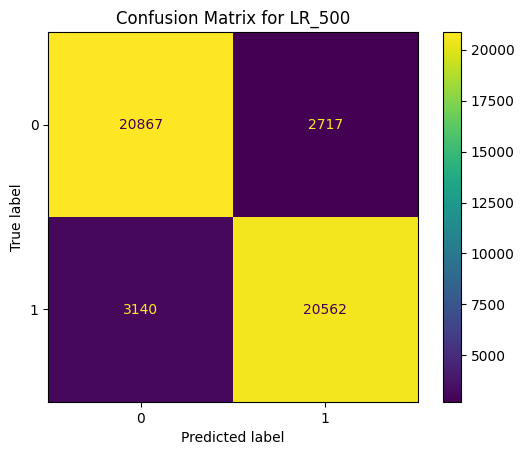

<Figure size 640x480 with 0 Axes>

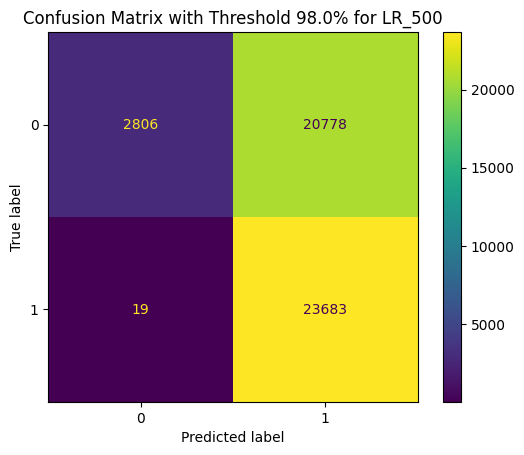

In [5]:
save_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models"
lr_500 = LR_training('LR_500', train_data=train_df, save_path=save_path, test_size=0.15, threshold=0.98)

## Train using Normal Volume

In [6]:
# load data
train_df_normal = pd.read_csv(os.path.join('data','train500_normal.csv'), index_col=0)
train_df_normal

,Volume,normalized_value,3_reg,5_reg,10_reg,20_reg,target
25,210496.0,1.000000,0.008049,0.013094,0.005900,0.001763,1
34,197101.0,0.000000,0.001073,-0.006225,-0.004378,0.002238,0
51,137779.0,0.500000,0.009689,0.008397,0.003458,0.000837,1
62,166483.0,1.000000,0.003229,0.000431,-0.000137,0.002058,1
65,168397.0,0.000000,-0.006997,-0.002261,-0.000528,0.001113,0
...,...,...,...,...,...,...,...
2895,3197400.0,0.426447,0.275002,-0.189001,0.162727,0.339736,0
2901,1732700.0,0.850681,-2.245003,-0.248000,0.646667,0.246474,1
2909,1262400.0,0.260869,-0.715004,-0.466002,-0.333697,0.196820,0
2926,1993800.0,0.524875,2.310005,1.498000,0.811576,0.727023,1


INFO:root:Created test and train data...
INFO:root:Training model...
/home/aitha/miniconda3/envs/stock_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aitha/miniconda3/envs/stock_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:root:Logistic regression model score: 0.8642086885077539
INFO:root:classification report
INFO:root:              precision    recall  f1-score   support

           0       0.85      0.88      0.86     24096
           1       0.88      0.85      0.86     24589

    accuracy                           0.86     48685
   macro avg       0.86      0.86      0.86     48685
weighted avg       0.86      0.86      0.86     48685

INFO:roo

<Figure size 640x480 with 0 Axes>

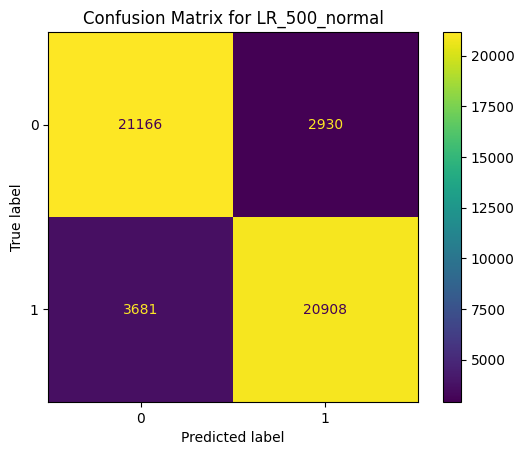

<Figure size 640x480 with 0 Axes>

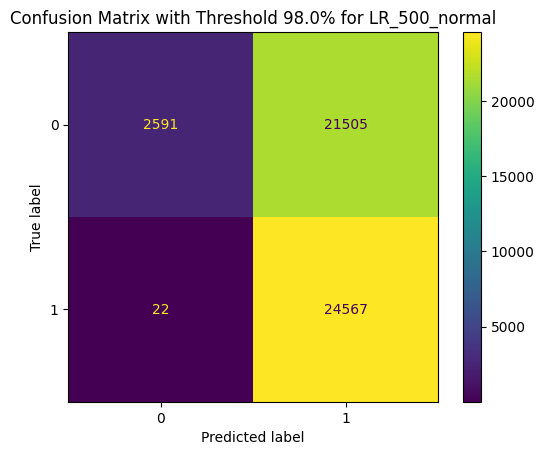

In [7]:
save_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models"
lr_500_nor = LR_training('LR_500_normal', train_data=train_df_normal, save_path=save_path, test_size=0.15, threshold=0.98)

# Inference and Visualize using LR 500 model
We will need the largest model we have created to inference and visualize resutls

- we will not use only min/max points as inference data
- all daily data will be used - there will be noise
- that is a real world scenario

## Get data for NVDA last year

In [12]:
b_date = '2023-01-01'
e_date = '2024-10-10'
data = fetch_data(['NVDA'], start_date=b_date, end_date=e_date, verbose=False)
nvda = data['NVDA']
nvda

INFO:root:Data fetched...


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03 00:00:00-05:00,14.841228,14.986133,14.086724,14.305580,401277000,0.0,0.0
1,2023-01-04 00:00:00-05:00,14.557417,14.843229,14.231632,14.739297,431324000,0.0,0.0
2,2023-01-05 00:00:00-05:00,14.481465,14.554417,14.138691,14.255614,389168000,0.0,0.0
3,2023-01-06 00:00:00-05:00,14.464477,15.000125,14.024767,14.849224,405044000,0.0,0.0
4,2023-01-09 00:00:00-05:00,15.273944,16.045436,15.131038,15.617718,504231000,0.0,0.0
...,...,...,...,...,...,...,...,...
440,2024-10-03 00:00:00-04:00,120.919998,124.360001,120.339996,122.849998,277118000,0.0,0.0
441,2024-10-04 00:00:00-04:00,124.940002,125.040001,121.830002,124.919998,243678100,0.0,0.0
442,2024-10-07 00:00:00-04:00,124.989998,130.639999,124.949997,127.720001,346250200,0.0,0.0
443,2024-10-08 00:00:00-04:00,130.259995,133.479996,129.419998,132.889999,285722500,0.0,0.0


In [13]:
def preprocess_stock(stock: pd.DataFrame, volume_type: str='normal', dropna: bool=False) -> pd.DataFrame:
    """
    preprocess the stock data
    """
    df = stock.copy()

    #columns of interest
    cols_of_interest = ['Volume', 'normalized_value', '3_reg', '5_reg', '10_reg', '20_reg', 'Close', 'Date']
    if volume_type == "relative":
        cols_of_interest[0] = 'relative_volume'
        df = relative_volume(df, 90)
        
    df['normalized_value'] = df.apply(lambda x: normalized_values(x.High, x.Low, x.Close), axis = 1)

    idxs = df.index.values.tolist()
    df = n_day_regression(3, df, idxs)
    df = n_day_regression(5, df, idxs)
    df = n_day_regression(10, df, idxs)
    df = n_day_regression(20, df, idxs)

    return df[cols_of_interest].dropna(axis = 0) if dropna else df[cols_of_interest]

### Preprocess uisng relative Volume

In [14]:
nvda_rel = nvda.copy()
nvda_rel = preprocess_stock(nvda_rel, volume_type='relative', dropna=True)
close_rel = nvda_rel.pop('Close')
dates_rel = nvda_rel.pop('Date')
nvda_rel

,relative_volume,normalized_value,3_reg,5_reg,10_reg,20_reg
89,0.691311,0.471589,-0.132934,0.253577,0.139689,0.109899
90,0.590251,0.400545,0.003497,-0.046977,0.086358,0.104373
91,0.634749,0.980415,-0.272368,-0.161421,0.038520,0.096926
92,0.969113,0.367051,0.187409,0.021889,0.094305,0.099704
93,0.932120,0.972692,0.436288,0.103050,0.117100,0.113757
...,...,...,...,...,...,...
440,0.795874,0.624378,-1.295002,-1.478001,0.265697,0.746970
441,0.709092,0.962616,2.924999,0.030999,0.312606,0.701843
442,1.014499,0.486820,3.035000,1.280999,0.287393,0.593602
443,0.842687,0.854681,2.435001,2.751000,0.324121,0.549598


### Preprocess using Normal Volume

In [15]:
nvda_nor = nvda.copy()
nvda_nor = preprocess_stock(nvda_nor, volume_type='relative', dropna=True)
close_nor = nvda_nor.pop('Close')
dates_nor = nvda_nor.pop('Date')
nvda_nor

,relative_volume,normalized_value,3_reg,5_reg,10_reg,20_reg
89,0.691311,0.471589,-0.132934,0.253577,0.139689,0.109899
90,0.590251,0.400545,0.003497,-0.046977,0.086358,0.104373
91,0.634749,0.980415,-0.272368,-0.161421,0.038520,0.096926
92,0.969113,0.367051,0.187409,0.021889,0.094305,0.099704
93,0.932120,0.972692,0.436288,0.103050,0.117100,0.113757
...,...,...,...,...,...,...
440,0.795874,0.624378,-1.295002,-1.478001,0.265697,0.746970
441,0.709092,0.962616,2.924999,0.030999,0.312606,0.701843
442,1.014499,0.486820,3.035000,1.280999,0.287393,0.593602
443,0.842687,0.854681,2.435001,2.751000,0.324121,0.549598


## Inference using the two models

In [16]:
save_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models"

In [17]:
def _threshold(predictions, threshold):

        prob_thresholded = [0 if x > threshold else 1 for x in predictions[:, 0]]

        return np.array(prob_thresholded)

### Using LR 500 model with relative Volume

In [18]:
# Define the paths to the saved model and scaler files
model_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models/lr_LR_500.sav"
scaler_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models/scaler_LR_500.sav"

# Load the saved model
with open(model_path, 'rb') as model_file:
    model_rel = pickle.load(model_file)

# Load the saved scaler
with open(scaler_path, 'rb') as scaler_file:
    scaler_rel = pickle.load(scaler_file)


In [19]:
pred_df = nvda_rel.copy() # this is the nvdia data

x = scaler_rel.fit_transform(pred_df)
logging.info('Created inference data...')

# Predict
predictions = model_rel.predict(x)

#preds with threshold
predictions_proba = model_rel._predict_proba_lr(x)
predictions_proba_thresholded = _threshold(predictions_proba, threshold=0.98)
logging.info('Predictions made...')

INFO:root:Created inference data...
INFO:root:Predictions made...


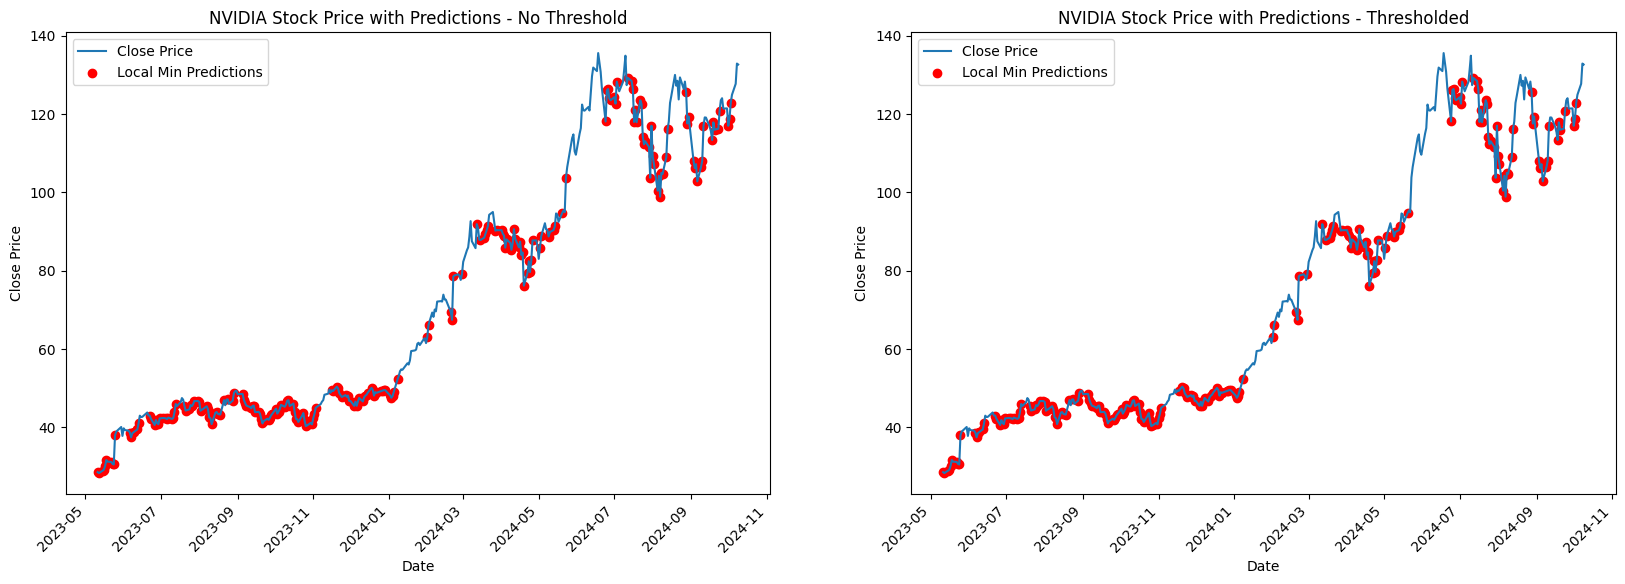

In [25]:
pred_df['predictions'] = predictions
pred_df['predictions_thresholded'] = predictions_proba_thresholded
pred_df['close'] = close_rel
pred_df['Date'] = dates_rel

# Reset the index to get the 'Date' column
pred_df_reset = pred_df.reset_index()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot without thresholded predictions
axes[0].plot(pred_df_reset['Date'], pred_df_reset['close'], label='Close Price')
axes[0].scatter(pred_df_reset['Date'][pred_df_reset['predictions'] == 0],
                pred_df_reset['close'][pred_df_reset['predictions'] == 0],
                color='red', label='Local Min Predictions')
axes[0].set_title("NVIDIA Stock Price with Predictions - No Threshold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Close Price")
axes[0].legend()

# Plot with thresholded predictions
axes[1].plot(pred_df_reset['Date'], pred_df_reset['close'], label='Close Price')
axes[1].scatter(pred_df_reset['Date'][pred_df_reset['predictions_thresholded'] == 0],
                pred_df_reset['close'][pred_df_reset['predictions_thresholded'] == 0],
                color='red', label='Local Min Predictions')
axes[1].set_title("NVIDIA Stock Price with Predictions - Thresholded")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Close Price")
axes[1].legend()

# Rotate date labels for better readability
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Show the plots
plt.savefig(os.path.join(save_path, 'figures', 'nvidia_predictions_LR_500_rel.jpg'))
plt.show()

### Using LR 500 model with Normal Volume

In [21]:
# Define the paths to the saved model and scaler files
model_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models/lr_LR_500_normal.sav"
scaler_path = r"/home/aitha/Documents/Git-Projects/Stock-Prediction/notebooks/Local_max_min/models/scaler_LR_500_normal.sav"

# Load the saved model
with open(model_path, 'rb') as model_file:
    model_nor = pickle.load(model_file)

# Load the saved scaler
with open(scaler_path, 'rb') as scaler_file:
    scaler_nor = pickle.load(scaler_file)

In [22]:
pred_df = nvda_nor.copy() # this is the nvdia data

x = scaler_rel.fit_transform(pred_df)
logging.info('Created inference data...')

# Predict
predictions = model_rel.predict(x)

#preds with threshold
predictions_proba = model_rel._predict_proba_lr(x)
predictions_proba_thresholded = _threshold(predictions_proba, threshold=0.98)
logging.info('Predictions made...')

INFO:root:Created inference data...
INFO:root:Predictions made...


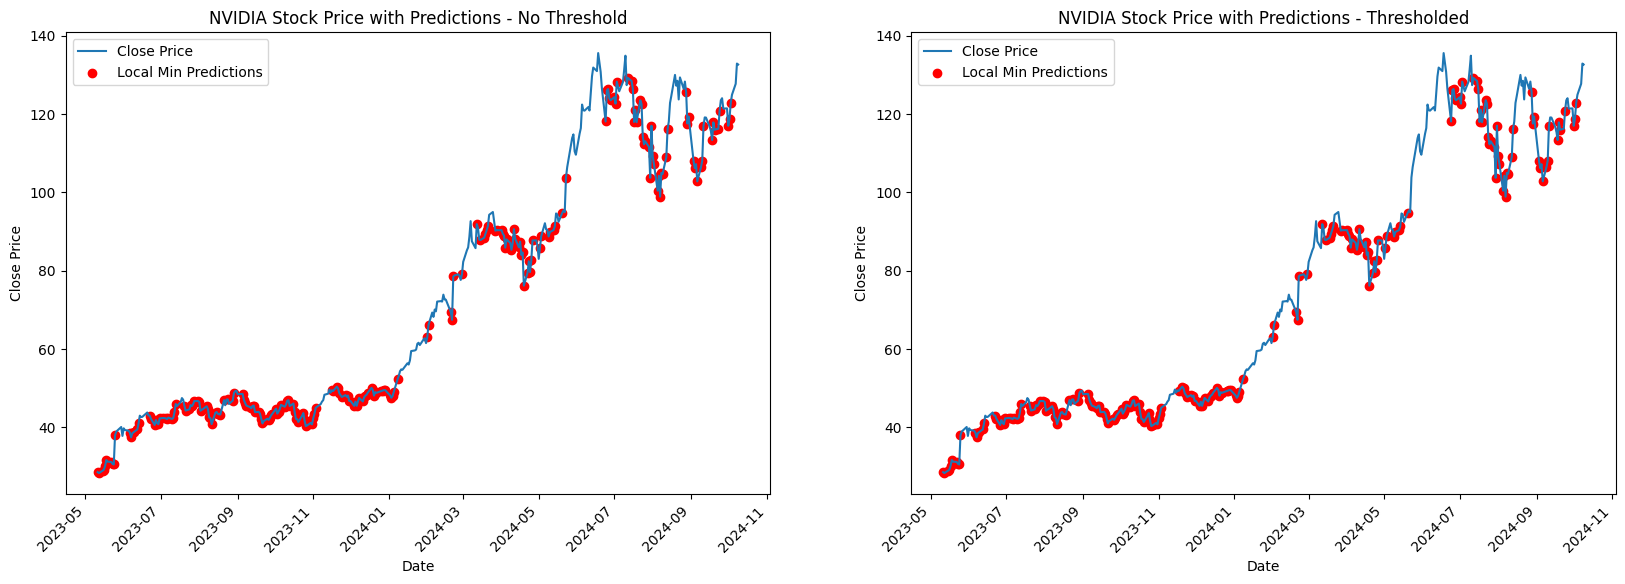

In [26]:
pred_df['predictions'] = predictions
pred_df['predictions_thresholded'] = predictions_proba_thresholded
pred_df['close'] = close_nor
pred_df['Date'] = dates_rel

# Reset the index to get the 'Date' column
pred_df_reset = pred_df.reset_index()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot without thresholded predictions
axes[0].plot(pred_df_reset['Date'], pred_df_reset['close'], label='Close Price')
axes[0].scatter(pred_df_reset['Date'][pred_df_reset['predictions'] == 0],
                pred_df_reset['close'][pred_df_reset['predictions'] == 0],
                color='red', label='Local Min Predictions')
axes[0].set_title("NVIDIA Stock Price with Predictions - No Threshold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Close Price")
axes[0].legend()

# Plot with thresholded predictions
axes[1].plot(pred_df_reset['Date'], pred_df_reset['close'], label='Close Price')
axes[1].scatter(pred_df_reset['Date'][pred_df_reset['predictions_thresholded'] == 0],
                pred_df_reset['close'][pred_df_reset['predictions_thresholded'] == 0],
                color='red', label='Local Min Predictions')
axes[1].set_title("NVIDIA Stock Price with Predictions - Thresholded")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Close Price")
axes[1].legend()

# Rotate date labels for better readability
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Show the plots
plt.savefig(os.path.join(save_path, 'figures', 'nvidia_predictions_LR_500_nor.jpg'))
plt.show()